In [ ]:
# Tier 3 data from Th-228

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as plt
import h5py
from pylab import *
from scipy import stats
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, ConstantModel
from lmfit import Model

In [2]:

#TOP
list = ['char_data-I02160A-th_HS2_top_psa-run0001-191021T163545_tier2.lh5', \
    'char_data-I02160A-th_HS2_top_psa-run0001-191021T163745_tier2.lh5', \
        'char_data-I02160A-th_HS2_top_psa-run0001-191021T163945_tier2.lh5', \
            'char_data-I02160A-th_HS2_top_psa-run0001-191021T164146_tier2.lh5', \
                'char_data-I02160A-th_HS2_top_psa-run0001-191021T164346_tier2.lh5' ]

Elist, AoElist = [], []
for i in range(len(list)):
    f = h5py.File(list[i], 'r')
    raw = f['raw']
    df = pd.DataFrame({'E': raw['trapE'][()], 'AoE': raw['AoE'][()]})
    for j in range(len(df)):
        Elist.append(df['E'][j]) ; AoElist.append(df['AoE'][j])    

print(len(Elist))

#LAT
list = ['char_data-I02160A-th_HS2_lat_psa-run0001-191023T092533_tier2.lh5', \
    'char_data-I02160A-th_HS2_lat_psa-run0001-191023T092733_tier2.lh5', \
        'char_data-I02160A-th_HS2_lat_psa-run0001-191023T092933_tier2.lh5', \
            'char_data-I02160A-th_HS2_lat_psa-run0001-191023T093134_tier2.lh5', \
                'char_data-I02160A-th_HS2_lat_psa-run0001-191023T093334_tier2.lh5']

Elist_lat, AoElist_lat = [], []
for i in range(len(list)):
    f = h5py.File(list[i], 'r')
    raw = f['raw']
    df = pd.DataFrame({'E': raw['trapE'][()], 'AoE': raw['AoE'][()]})
    for j in range(len(df)):
        Elist_lat.append(df['E'][j]) ; AoElist_lat.append(df['AoE'][j])    

print(len(Elist_lat))

483160
382152


In [ ]:
#TOP energy normalization
#ŷ = 0.06574X + 38.18536
Etop_norm = []
for i in range(len(Elist)):
    ss = 0.06574*Elist[i] + 38.18536
    Etop_norm.append(ss)
    
#Lateral energy normalization
#ŷ = 0.06558X + 4.87179
Elat_norm = []
for i in range(len(Elist_lat)):
    mm = 0.06558*Elist_lat[i] + 4.87179
    Elat_norm.append(mm)

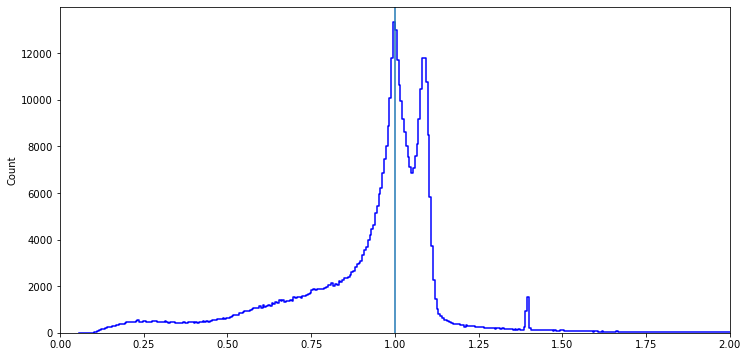

In [3]:
# A/E Data normalization

aoe_lat_norm = []
for i in range(len(AoElist_lat)):
    aa = AoElist_lat[i]/0.06243508   #/0.05243508
    aoe_lat_norm.append(aa)

aoe_top_norm = []
for i in range(len(AoElist)):
    bb = AoElist[i]/0.06343508   #/0.05243508
    aoe_top_norm.append(bb)

fig = plt.figure(figsize=(12,6))
sns.histplot(data=aoe_lat_norm, log_scale=False, element="step", fill=False, color='b', label='Lat')
sns.histplot(data=aoe_top_norm, log_scale=False, element="step", fill=False, color='r', label='Top')
plt.xlim(0,2)
plt.axvline(1)

In [ ]:
fig = plt.figure(figsize=(14,6))
x, y = np.asarray(Elat_norm), np.asarray(AoElist_lat)
plt.hist2d(x, y, bins=(5000, 5000),  norm=mpl.colors.LogNorm(), cmap='rainbow')
#plt.scatter(x, res , c=z, s=2, alpha=0.1,  norm=LogNorm(vmin=z.min(), vmax=z.max()), cmap='hsv')

plt.colorbar()
plt.xlim(0,500)
plt.ylim(0,0.3)
plt.ylabel('A/E [a.u.]')
plt.xlabel('Energy [keV]')
plt.grid(True)
plt.title("Tier-2 HADES-Th-I02160A / Lat")
plt.legend()
plt.savefig('Th_AoE_map_lat.png')

In [ ]:
# Fitting A/E Slices

<ipython-input-7-e99e1109c8ad>:20: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-7-e99e1109c8ad>:20: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)


595


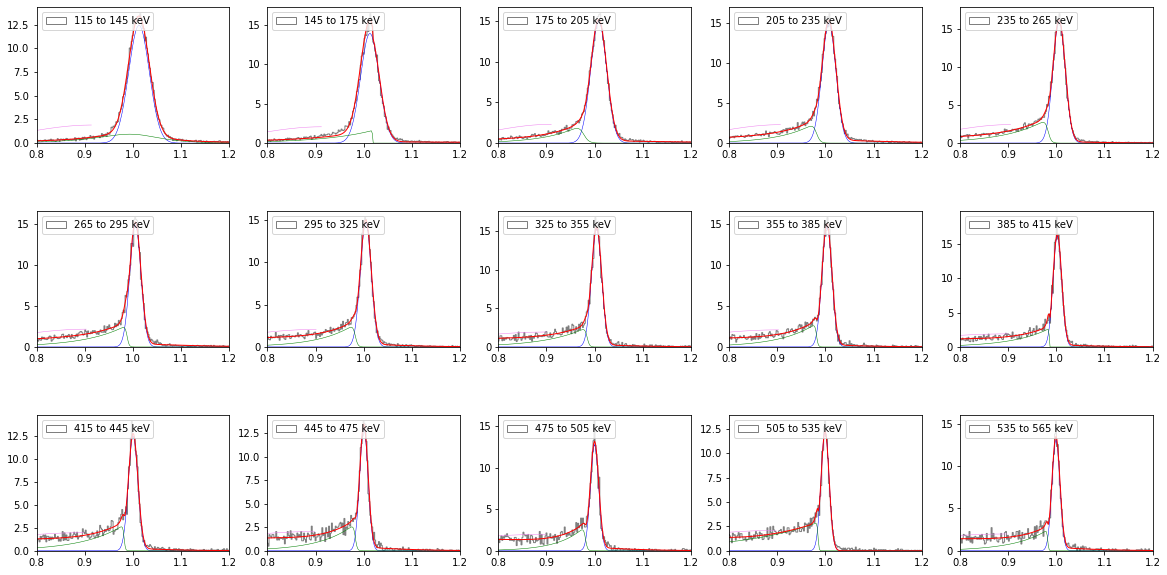

In [7]:
# New Model 
#Lateral
#-------------------------------------------------------
A , B, w = 115, 145, 30           #start - end - energy window  
n = 600                           #800
binw = 0.002    #bin width 0.008 , 0.0045, 0.002
#------------------------------- --------------------------------------------------------------- Models
def gauss(x, amp, center, sigma):
    return amp/(np.sqrt(2*np.pi))/sigma*(np.exp(-0.5*((x-center)/sigma)**2))
def tail(x, m, f, l, d, t):
    return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
def fexpo(x, f, a):
    return exp(f * x + a)
def totalfit(x, ampl, mu, std, m, f, l, t, ampl2, mu2, std2):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t) + gauss(x, ampl2, mu2, std2)
#--------------------------------------------------------------------------------------------- Figure settings
fig, axs = plt.subplots(3,5, figsize=(20,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace = 0.2)
axs = axs.ravel()
#--------------------------------------------------------------------------------------------- Fitting parameters
chi1 = []
means = []
meanstot1 = []
stds  =  []
stdtot1 = []
xticks1 = []
centroid_list = []
#------------------------------------------------------- data extraction
for j in range(15):
    data =[]
    for i in range(len(Elist_lat)):
        if (Elat_norm[i] > A and Elat_norm[i]< B) & (aoe_lat_norm[i] > 0.2 and aoe_lat_norm[i] < 1.6):
            data.append(aoe_lat_norm[i])
    xdata = np.asarray(data)
#-------------------------------------------------------
#------------------------------------------------------- bins and centroid
    b = len(np.arange(min(xdata), max(xdata) + binw, binw))
    y,x,_= axs[j].hist(xdata, \
                       bins = b, \
                       histtype=u'step', density=True, alpha=0.5, color='k', \
                       label='%.f to %.f keV' %(A, B))

    x = (x[1:]+x[:-1])/2    
    centroid = x[np.argmax(y)]
    centroid_list.append(centroid)
#-------------------------------------------------------
    
#------------------------------------------------------- Gaussian model        
    model1 = Model(gauss, prefix='g_')
    paramslm = model1.make_params(g_amp=len(xdata), g_center=centroid, g_sigma=centroid*0.01)
    paramslm['g_amp'].min = 0.
    paramslm['g_center'].min = centroid * 0.9
    paramslm['g_center'].max = centroid * 1.1
    paramslm['g_sigma'].min = 0
    paramslm['g_sigma'].max = 1
    
    result1 = model1.fit(y[(x>centroid*0.985) & (x<centroid*1.2)], paramslm, x=x[(x>centroid*0.985) & (x<centroid*1.2)])
    means.append(result1.params['g_center'].value)
    stds.append(result1.params['g_sigma'].value)
    xticks1.append(A)

#-------------------------------------------------------EXTRAMODEL
    model4 = Model(gauss, prefix='e_')
    paramslm4 = model4.make_params(e_amp=len(xdata), e_center=centroid*0.6, e_sigma=centroid*0.01)
    paramslm4['e_amp'].min = 0.
    paramslm4['e_center'].min = centroid * 0.5
    paramslm4['e_center'].max = centroid * 0.9
    paramslm4['e_sigma'].min = 0
    paramslm4['e_sigma'].max = 1
    
    result4 = model4.fit(y[(x>centroid*0.1) & (x<centroid*0.995)], paramslm4, x=x[(x>centroid*0.1) & (x<centroid*0.995)])

#------------------------------------------------------- Expo
    model3 = Model(fexpo, prefix='e_') 
    paramslmex = model3.make_params(e_f=1, e_a=1)
    
    expo_min = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    expo_max = result1.params['g_center'].value - 4*result1.params['g_sigma'].value
    
    fmin = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    fmax = result1.params['g_center'].value + 10*result1.params['g_sigma'].value

    result3 = model3.fit(y[x>fmin], paramslmex, x=x[x>fmin])    
#-------------------------------------------------------

#------------------------------------------------------- The tail(from direct model)
    enteries = 0
    for i in range(len(xdata)):
        if (xdata[i] < result1.params['g_center'].value  - 3*result1.params['g_sigma'].value) & \
        (xdata[i] > result1.params['g_center'].value  - 25*result1.params['g_sigma'].value):
            enteries = enteries +1
    model2 = Model(tail, prefix='t_') 
    paramslm2 = model2.make_params(t_m= enteries * result1.params['g_center'].value, \
                              t_f= result3.params['e_f'].value, \
                              t_l= result1.params['g_center'].value - 1.2 * result1.params['g_sigma'].value, \
                              t_d= 0 ,\
                              t_t= 0.2 * result1.params['g_sigma'].value )
    paramslm2['t_d'].vary = False
    
    min_tail = result1.params['g_center'].value - 25 * result1.params['g_sigma'].value
    max_tail = result1.params['g_center'].value + 10 * result1.params['g_sigma'].value
    
    result2 = model2.fit(y[(x>min_tail) & (x<max_tail)], paramslm2, x=x[(x>min_tail) & (x<max_tail)])
#-------------------------------------------------------
    
    modeltot = Model(totalfit, prefix='tot_') 
    paramstot = modeltot.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value, \
                                     tot_ampl2=result4.params['e_amp'].value, \
                                     tot_mu2=result4.params['e_center'].value, \
                                     tot_std2=result4.params['e_sigma'].value)
    
    paramstot['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot['tot_m'].min  = 0
    paramstot['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot['tot_t'].min  = 0
    paramstot['tot_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    #resulttot = modeltot.fit(y, paramstot, x=x, weights=np.sqrt(1.0/np.std(AoE)))
    weight = 1/np.std(xdata)
    resulttot = modeltot.fit(y, paramstot, x=x)#, weights=weight)
    chi1.append(resulttot.redchi)
    meanstot1.append(resulttot.params['tot_mu'].value)
    stdtot1.append(resulttot.params['tot_std'].value)
    #------------------------------------------------------- Total fit
    SSE = gauss(x, resulttot.params['tot_ampl'].value, resulttot.params['tot_mu'].value, resulttot.params['tot_std'].value)
    MSE = tail(x, resulttot.params['tot_m'].value, resulttot.params['tot_f'].value, \
               resulttot.params['tot_l'].value, 0, resulttot.params['tot_t'].value)
    plateau = gauss(x[(x>centroid*0.1) & (x<centroid*0.9)], result4.params['e_amp'].value, result4.params['e_center'].value, result4.params['e_sigma'].value)
#-------------------------------------------------------
#------------------------------------------------------- Plotting
    axs[j].plot(x, SSE, color='b', lw=0.5)
    axs[j].plot(x, MSE, color='g', lw=0.5)
    axs[j].plot(x[(x>centroid*0.1) & (x<centroid*0.9)], plateau, color='violet', lw=0.5)
    axs[j].plot(x, resulttot.best_fit, color='r', lw=1)
    axs[j].legend(loc=2, prop={'size': 10})
    axs[j].set_xlim(0.8,1.2)
    #axs[j].set_xlim(0.02,0.06)
    #axs[j].set_xticks([0.1,1.0,1.5])
    A = A + w
    B = B + w
    
#fig.suptitle('Inverted Coax det=37, run-0112 \n %.f keV window'%(w), fontsize=20)
#plt.savefig('from 100 to %.f keV (binw=%.4f).pdf'%(B,binw))
print(B)

#------------------------------------------------------- Stats



In [5]:
#OLD Model

#Lateral
#-------------------------------------------------------
A , B, w = 115, 145, 30           #start - end - energy window  
n = 500
binw = 0.002      #bin width 0.008 , 0.0045, 0.002
#------------------------------- --------------------------------------------------------------- Models
def gauss(x, amp, center, sigma):
    return amp/(np.sqrt(2*np.pi))/sigma*(np.exp(-0.5*((x-center)/sigma)**2))
def tail(x, m, f, l, d, t):
    return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
def fexpo(x, f, a):
    return exp(f * x + a)
def totalfit(x, ampl, mu, std, m, f, l, t):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t)
#--------------------------------------------------------------------------------------------- Figure settings
fig, axs = plt.subplots(3,5, figsize=(20,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace = 0.2)
axs = axs.ravel()
#--------------------------------------------------------------------------------------------- Fitting parameters
chi2 = []
means = []
meanstot2 = []
stds  =  []
stdtot2 = []
xticks2 = []
centroid_list = []
#------------------------------------------------------- data extraction
for j in range(15):
    data =[]
    for i in range(len(Elist_lat)):
        if (Elat_norm[i] > A and Elat_norm[i]< B) & (aoe_lat_norm[i] > 0.2 and aoe_lat_norm[i] < 1.6):
            data.append(aoe_lat_norm[i])
    xdata = np.asarray(data)
#-------------------------------------------------------
#------------------------------------------------------- bins and centroid
    b = len(np.arange(min(xdata), max(xdata) + binw, binw))
    y,x,_= axs[j].hist(xdata, \
                       bins = b, \
                       histtype=u'step', density=True, alpha=0.5, color='k', \
                       label='%.f to %.f keV'%(A, B))

    x = (x[1:]+x[:-1])/2    
    centroid = x[np.argmax(y)]
    centroid_list.append(centroid)
#-------------------------------------------------------
    
#------------------------------------------------------- Gaussian model        
    model1 = Model(gauss, prefix='g_')
    paramslm = model1.make_params(g_amp=len(xdata), g_center=centroid, g_sigma=centroid*0.01)
    paramslm['g_amp'].min = 0.
    paramslm['g_center'].min = centroid * 0.9
    paramslm['g_center'].max = centroid * 1.1
    paramslm['g_sigma'].min = 0
    paramslm['g_sigma'].max = 1
    
    result1 = model1.fit(y[(x>centroid*0.985) & (x<centroid*1.2)], paramslm, x=x[(x>centroid*0.985) & (x<centroid*1.2)])
    means.append(result1.params['g_center'].value)
    stds.append(result1.params['g_sigma'].value)
    #xticks.append('%.f - %.f'%(A,B))
    xticks2.append(A)

#-------------------------------------------------------

#------------------------------------------------------- Expo
    model3 = Model(fexpo, prefix='e_') 
    paramslmex = model3.make_params(e_f=1, e_a=1)
    
    expo_min = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    expo_max = result1.params['g_center'].value - 4*result1.params['g_sigma'].value
    
    fmin = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    fmax = result1.params['g_center'].value + 10*result1.params['g_sigma'].value

    result3 = model3.fit(y[x>fmin], paramslmex, x=x[x>fmin])    
#-------------------------------------------------------

#------------------------------------------------------- The tail(from direct model)
    enteries = 0
    for i in range(len(xdata)):
        if (xdata[i] < result1.params['g_center'].value  - 3*result1.params['g_sigma'].value) & \
        (xdata[i] > result1.params['g_center'].value  - 25*result1.params['g_sigma'].value):
            enteries = enteries +1
    model2 = Model(tail, prefix='t_') 
    paramslm2 = model2.make_params(t_m= enteries * result1.params['g_center'].value, \
                              t_f= result3.params['e_f'].value, \
                              t_l= result1.params['g_center'].value - 1.5 * result1.params['g_sigma'].value, \
                              t_d= 0 ,\
                              t_t= 0.2 * result1.params['g_sigma'].value )
    #paramslm2['t_m'].min  = 0.
    #paramslm2['t_m'].max  = 10  * paramslm2['t_m']
    #paramslm2['t_f'].min  = 0.2 * result3.params['e_f'].value
    #paramslm2['t_f'].max  = 5.0 * result3.params['e_f'].value
    #paramslm2['t_l'].min  = 0.5 * paramslm2['t_l']
    #paramslm2['t_l'].max  = 2.0 * paramslm2['t_l']
    #paramslm2['t_l'].vary = False
    paramslm2['t_d'].vary = False
    #paramslm2['t_t'].min  = 0.
    #paramslm2['t_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    min_tail = result1.params['g_center'].value - 25 * result1.params['g_sigma'].value
    max_tail = result1.params['g_center'].value + 10 * result1.params['g_sigma'].value
    
    result2 = model2.fit(y[(x>min_tail) & (x<max_tail)], paramslm2, x=x[(x>min_tail) & (x<max_tail)])
#-------------------------------------------------------
    
    modeltot = Model(totalfit, prefix='tot_') 
    paramstot = modeltot.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value)
    
    paramstot['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot['tot_m'].min  = 0
    paramstot['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot['tot_t'].min  = 0
    paramstot['tot_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    #resulttot = modeltot.fit(y, paramstot, x=x, weights=np.sqrt(1.0/np.std(AoE)))
    weight = 1/np.std(xdata)
    resulttot = modeltot.fit(y, paramstot, x=x, weights=weight)
    
    chi2.append(resulttot.redchi)
    meanstot2.append(resulttot.params['tot_mu'].value)
    stdtot2.append(resulttot.params['tot_std'].value)
    #------------------------------------------------------- Total fit
    SSE = gauss(x, resulttot.params['tot_ampl'].value, resulttot.params['tot_mu'].value, resulttot.params['tot_std'].value)
    MSE = tail(x, resulttot.params['tot_m'].value, resulttot.params['tot_f'].value, \
               resulttot.params['tot_l'].value, 0, resulttot.params['tot_t'].value)
#-------------------------------------------------------
#------------------------------------------------------- Plotting
    axs[j].plot(x, SSE, color='b', lw=0.5) #, label='Gaussian')
    axs[j].plot(x, MSE, color='g', lw=0.5) #, label='Tail')
    axs[j].plot(x, resulttot.best_fit, color='r', lw=1) #, label='Fit')
    #axs[j].legend(loc=2, prop={'size': 7})
    axs[j].set_xlim(0.8,1.2)
    #axs[j].set_xticks([0.1,1.0,1.5])
    axs[j].legend(loc=2, prop={'size': 10})
    A = A + w
    B = B + w

#fig.suptitle('Inverted Coax det=37, run-0112 \n %.f keV window'%(w), fontsize=20)
#plt.savefig('from 100 to %.f keV (binw=%.4f).pdf'%(B,binw))
plt.savefig('plots/(edited)Th-228-lat-old_model_2_(115-%.f).pdf'%(B))

print(B)
#------------------------------------------------------- Stats
#------------------------------------------------------- Stats


<ipython-input-5-d60ca4e8ad0d>:20: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)


595


In [ ]:
# Compare the two models

<ipython-input-11-b7d68a307ba3>:18: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-11-b7d68a307ba3>:18: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-11-b7d68a307ba3>:18: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)


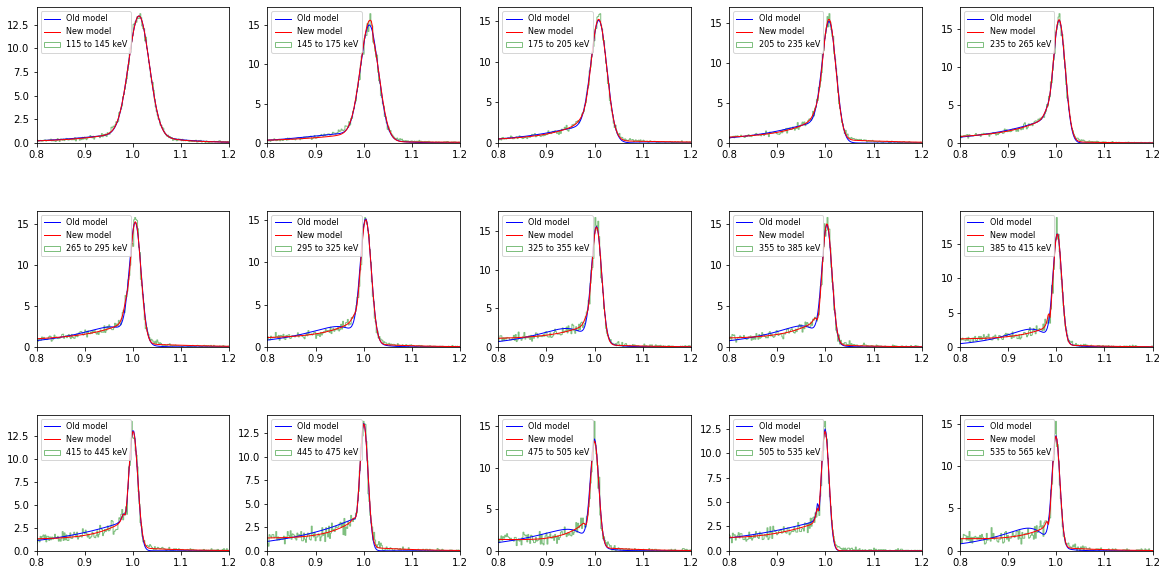

In [11]:
A , B, w = 115, 145, 30           #start - end - energy window  
n = 500
binw = 0.002      #bin width 0.008 , 0.0045, 0.002
#------------------------------- --------------------------------------------------------------- Models
def gauss(x, amp, center, sigma):
    return amp/(np.sqrt(2*np.pi))/sigma*(np.exp(-0.5*((x-center)/sigma)**2))
def tail(x, m, f, l, d, t):
    return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
def fexpo(x, f, a):
    return exp(f * x + a)
def totalfit(x, ampl, mu, std, m, f, l, t, ampl2, mu2, std2):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t) + gauss(x, ampl2, mu2, std2)
def totalfit_old(x, ampl, mu, std, m, f, l, t):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t)
#--------------------------------------------------------------------------------------------- Figure settings
fig, axs = plt.subplots(3,5, figsize=(20,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace = 0.2)
axs = axs.ravel()
#--------------------------------------------------------------------------------------------- Fitting parameters
chi = []
means = []
meanstot = []
stds  =  []
stdtot = []
xticks = []
centroid_list = []
#------------------------------------------------------- data extraction
for j in range(15):
    data =[]
    for i in range(len(Elist_lat)):
        if (Elat_norm[i] > A and Elat_norm[i]< B) & (aoe_lat_norm[i] > 0.2 and aoe_lat_norm[i] < 1.6):
            data.append(aoe_lat_norm[i])
    xdata = np.asarray(data)
#-------------------------------------------------------
#------------------------------------------------------- bins and centroid
    b = len(np.arange(min(xdata), max(xdata) + binw, binw))
    y,x,_= axs[j].hist(xdata, \
                       bins = b, \
                       histtype=u'step', density=True, alpha=0.5, color='g', \
                       label='%.f to %.f keV' %(A, B))

    x = (x[1:]+x[:-1])/2    
    centroid = x[np.argmax(y)]
    centroid_list.append(centroid)
#-------------------------------------------------------
    
#------------------------------------------------------- Gaussian model        
    model1 = Model(gauss, prefix='g_')
    paramslm = model1.make_params(g_amp=len(xdata), g_center=centroid, g_sigma=centroid*0.01)
    paramslm['g_amp'].min = 0.
    paramslm['g_center'].min = centroid * 0.9
    paramslm['g_center'].max = centroid * 1.1
    paramslm['g_sigma'].min = 0
    paramslm['g_sigma'].max = 1
    
    result1 = model1.fit(y[(x>centroid*0.985) & (x<centroid*1.2)], paramslm, x=x[(x>centroid*0.985) & (x<centroid*1.2)])
    means.append(result1.params['g_center'].value)
    stds.append(result1.params['g_sigma'].value)
    xticks.append(A)

#-------------------------------------------------------EXTRAMODEL
    model4 = Model(gauss, prefix='e_')
    paramslm4 = model4.make_params(e_amp=len(xdata), e_center=centroid*0.6, e_sigma=centroid*0.01)
    paramslm4['e_amp'].min = 0.
    paramslm4['e_center'].min = centroid * 0.5
    paramslm4['e_center'].max = centroid * 0.9
    paramslm4['e_sigma'].min = 0
    paramslm4['e_sigma'].max = 1
    
    result4 = model4.fit(y[(x>centroid*0.1) & (x<centroid*0.9)], paramslm4, x=x[(x>centroid*0.1) & (x<centroid*0.9)])

#------------------------------------------------------- Expo
    model3 = Model(fexpo, prefix='e_') 
    paramslmex = model3.make_params(e_f=1, e_a=1)
    
    expo_min = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    expo_max = result1.params['g_center'].value - 4*result1.params['g_sigma'].value
    
    fmin = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    fmax = result1.params['g_center'].value + 10*result1.params['g_sigma'].value

    result3 = model3.fit(y[x>fmin], paramslmex, x=x[x>fmin])    
#-------------------------------------------------------

#------------------------------------------------------- The tail(from direct model)
    enteries = 0
    for i in range(len(xdata)):
        if (xdata[i] < result1.params['g_center'].value  - 3*result1.params['g_sigma'].value) & \
        (xdata[i] > result1.params['g_center'].value  - 25*result1.params['g_sigma'].value):
            enteries = enteries +1
    model2 = Model(tail, prefix='t_') 
    paramslm2 = model2.make_params(t_m= enteries * result1.params['g_center'].value, \
                              t_f= result3.params['e_f'].value, \
                              t_l= result1.params['g_center'].value - 1.2 * result1.params['g_sigma'].value, \
                              t_d= 0 ,\
                              t_t= 0.2 * result1.params['g_sigma'].value )
    paramslm2['t_d'].vary = False
    
    min_tail = result1.params['g_center'].value - 25 * result1.params['g_sigma'].value
    max_tail = result1.params['g_center'].value + 10 * result1.params['g_sigma'].value
    
    result2 = model2.fit(y[(x>min_tail) & (x<max_tail)], paramslm2, x=x[(x>min_tail) & (x<max_tail)])
#-------------------------------------------------------
    
    modeltot = Model(totalfit, prefix='tot_') 
    paramstot = modeltot.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value, \
                                     tot_ampl2=result4.params['e_amp'].value, \
                                     tot_mu2=result4.params['e_center'].value, \
                                     tot_std2=result4.params['e_sigma'].value)
    
    paramstot['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot['tot_m'].min  = 0
    paramstot['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot['tot_t'].min  = 0
    paramstot['tot_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    #resulttot = modeltot.fit(y, paramstot, x=x, weights=np.sqrt(1.0/np.std(AoE)))
    weight = 1/np.std(xdata)
    resulttot = modeltot.fit(y, paramstot, x=x)#, weights=weight)
    chi.append(resulttot.redchi)
    
    #------------------------
    modeltot_old = Model(totalfit_old, prefix='tot_') 
    paramstot_old = modeltot_old.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value)
    
    paramstot_old['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot_old['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot_old['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot_old['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot_old['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot_old['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot_old['tot_m'].min  = 0
    paramstot_old['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot_old['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot_old['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot_old['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot_old['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot_old['tot_t'].min  = 0
    paramstot_old['tot_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    #resulttot = modeltot.fit(y, paramstot, x=x, weights=np.sqrt(1.0/np.std(AoE)))
    weight = 1/np.std(xdata)
    resulttot_old = modeltot_old.fit(y, paramstot_old, x=x)#, weights=weight)

    #------------------------------------------------------- Total fit
    SSE = gauss(x, resulttot.params['tot_ampl'].value, resulttot.params['tot_mu'].value, resulttot.params['tot_std'].value)
    MSE = tail(x, resulttot.params['tot_m'].value, resulttot.params['tot_f'].value, \
               resulttot.params['tot_l'].value, 0, resulttot.params['tot_t'].value)
    plateau = gauss(x[(x>centroid*0.1) & (x<centroid*0.9)], result4.params['e_amp'].value, result4.params['e_center'].value, result4.params['e_sigma'].value)
#-------------------------------------------------------
#------------------------------------------------------- Plotting
#     axs[j].plot(x, SSE, color='r', lw=0.5)
#     axs[j].plot(x, MSE, color='b', lw=0.5)
#     axs[j].plot(x[(x>centroid*0.1) & (x<centroid*0.9)], plateau, color='violet', lw=0.5, label='Extra gaussian')
    axs[j].plot(x, resulttot_old.best_fit, color='b', lw=1, label='Old model')
    axs[j].plot(x, resulttot.best_fit, color='r', lw=1, label='New model')
    axs[j].legend(loc=2, prop={'size': 8})
    axs[j].set_xlim(0.8,1.2)
    #axs[j].set_xlim(0.02,0.06)
#     axs[j].set_xticks([0.01,0.05])
    A = A + w
    B = B + w

#fig.suptitle('Inverted Coax det=37, run-0112 \n %.f keV window'%(w), fontsize=20)
#plt.savefig('from 100 to %.f keV (binw=%.4f).pdf'%(B,binw))
# plt.savefig('new_plots/IC2_run0113_2_(355-%.f).pdf'%(B))
#print(chi)


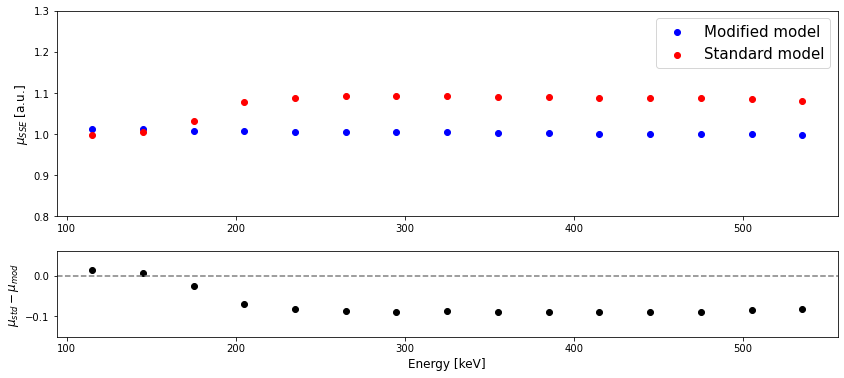

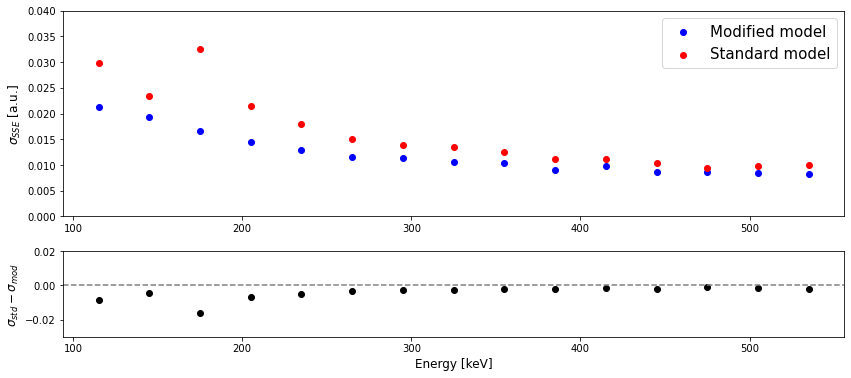

In [44]:
delta_m = []
for i in range(len(meanstot1)):
    value = meanstot1[i] - meanstot2[i]
    delta_m.append(value)
    

fig = plt.figure(figsize=(14, 6))

grid = plt.GridSpec(14,8, hspace=0.8, wspace=0.0)
y = fig.add_subplot(grid[0:9, 0:])
y.scatter(xticks2, meanstot1, marker='o', color='b', label='Modified model')
y.scatter(xticks2, meanstot2, marker='o', color='r', label='Standard model') 
y.legend(prop={'size': 15})
y.set_ylabel('$\u03BC_{SSE}$ [a.u.]', fontsize=12)
y.set_ylim(0.8, 1.3)

x = fig.add_subplot(grid[10:, 0:])
x.scatter(xticks2, delta_m, color='black')
x.axhline(0, linestyle='--', color='grey')

x.set_ylim(-0.15, 0.06)
x.set_ylabel('$\u03BC_{std}-\u03BC_{mod}$', fontsize=12)
x.set_xlabel('Energy [keV]', fontsize=12)

plt.savefig('ICsigma(LEGEND)(newvsold)(mean).pdf')


delta = []
for i in range(len(stdtot1)):
    value = stdtot1[i] - stdtot2[i]
    delta.append(value)
    

fig = plt.figure(figsize=(14, 6))

grid = plt.GridSpec(14,8, hspace=0.8, wspace=0.0)
y = fig.add_subplot(grid[0:9, 0:])
y.scatter(xticks2, stdtot1, marker='o', color='b', label='Modified model')
y.scatter(xticks2, stdtot2, marker='o', color='r', label='Standard model') 
y.legend(prop={'size': 15})
y.set_ylabel('$\u03C3_{SSE}$ [a.u.]', fontsize=12)
y.set_ylim(0.0, 0.04)

x = fig.add_subplot(grid[10:, 0:])
x.scatter(xticks2, delta, color='black')
x.axhline(0, linestyle='--', color='grey')

x.set_ylim(-0.03, 0.02)
x.set_ylabel('$\u03C3_{std}-\u03C3_{mod}$', fontsize=12)
x.set_xlabel('Energy [keV]', fontsize=12)

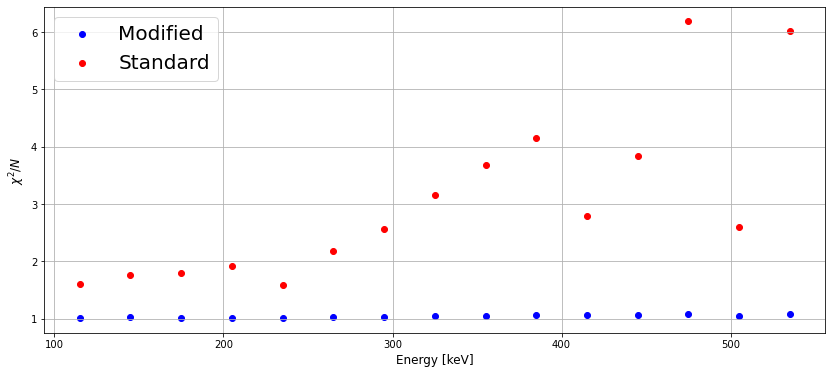

In [14]:
chi_new = []
chi_old = []

for i in range(len(chi1)):
    value = chi1[i]+1
    value2 = chi2[i]+1
    chi_new.append(value)
    chi_old.append(value2)

fig = plt.figure(figsize=(14,6))
plt.scatter(xticks1, chi_new, marker='o', color='b', label='Modified')
plt.scatter(xticks2, chi_old, marker='o', color='r', label='Standard')
plt.ylabel('$\u03C7^{2}/N$', fontsize=12)
plt.xlabel('Energy [keV]', fontsize=12)
plt.grid()
plt.legend(prop={'size': 20})

plt.savefig('ICsigma(LEGEND)(newvsold)(chi).pdf')



In [7]:
#------------------------------------------------------------------------------------------------------------------

#-------------------------------------------------------
A , B, w = 115, 145, 30           #start - end - energy window  
n = 500
binw = 0.002      #bin width 0.008 , 0.0045, 0.002
#------------------------------- --------------------------------------------------------------- Models
def gauss(x, amp, center, sigma):
    return amp/(np.sqrt(2*np.pi))/sigma*(np.exp(-0.5*((x-center)/sigma)**2))
def tail(x, m, f, l, d, t):
    return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
def fexpo(x, f, a):
    return exp(f * x + a)
def totalfit(x, ampl, mu, std, m, f, l, t, ampl2, mu2, std2):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t) + gauss(x, ampl2, mu2, std2)
def totalfit_old(x, ampl, mu, std, m, f, l, t):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t)
#--------------------------------------------------------------------------------------------- Figure settings
fig, axs = plt.subplots(6,5, figsize=(10,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace = 0.2)
axs = axs.ravel()
#--------------------------------------------------------------------------------------------- Fitting parameters
chi = []
means = []
meanstot_old = []
meanstot_new = []
stds  =  []
stdtot_old = []
stdtot_new = []
xticks = []
centroid_list = []
#------------------------------------------------------- data extraction
for j in range(30):
    data =[]
    for i in range(len(Elist_lat)):
        if (Elat_norm[i] > A and Elat_norm[i]< B) & (aoe_lat_norm[i] > 0.2 and aoe_lat_norm[i] < 1.6):
            data.append(aoe_lat_norm[i])
    xdata = np.asarray(data)
#-------------------------------------------------------
#------------------------------------------------------- bins and centroid
    b = len(np.arange(min(xdata), max(xdata) + binw, binw))
    y,x,_= axs[j].hist(xdata, \
                       bins = b, \
                       histtype=u'step', density=True, alpha=0.5, color='orange', \
                       label='%.f to %.f keV' %(A, B))

    x = (x[1:]+x[:-1])/2    
    centroid = x[np.argmax(y)]
    centroid_list.append(centroid)
#-------------------------------------------------------
    
#------------------------------------------------------- Gaussian model        
    model1 = Model(gauss, prefix='g_')
    paramslm = model1.make_params(g_amp=len(xdata), g_center=centroid, g_sigma=centroid*0.01)
    paramslm['g_amp'].min = 0.
    paramslm['g_center'].min = centroid * 0.9
    paramslm['g_center'].max = centroid * 1.1
    paramslm['g_sigma'].min = 0
    paramslm['g_sigma'].max = 1
    
    result1 = model1.fit(y[(x>centroid*0.985) & (x<centroid*1.2)], paramslm, x=x[(x>centroid*0.985) & (x<centroid*1.2)])
    means.append(result1.params['g_center'].value)
    stds.append(result1.params['g_sigma'].value)
    xticks.append(A)

#-------------------------------------------------------EXTRAMODEL
    model4 = Model(gauss, prefix='e_')
    paramslm4 = model4.make_params(e_amp=len(xdata), e_center=centroid*0.6, e_sigma=centroid*0.01)
    paramslm4['e_amp'].min = 0.
    paramslm4['e_center'].min = centroid * 0.5
    paramslm4['e_center'].max = centroid * 0.9
    paramslm4['e_sigma'].min = 0
    paramslm4['e_sigma'].max = 1
    
    result4 = model4.fit(y[(x>centroid*0.1) & (x<centroid*0.9)], paramslm4, x=x[(x>centroid*0.1) & (x<centroid*0.9)])

#------------------------------------------------------- Expo
    model3 = Model(fexpo, prefix='e_') 
    paramslmex = model3.make_params(e_f=1, e_a=1)
    
    expo_min = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    expo_max = result1.params['g_center'].value - 4*result1.params['g_sigma'].value
    
    fmin = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    fmax = result1.params['g_center'].value + 10*result1.params['g_sigma'].value

    result3 = model3.fit(y[x>fmin], paramslmex, x=x[x>fmin])    
#-------------------------------------------------------

#------------------------------------------------------- The tail(from direct model)
    enteries = 0
    for i in range(len(xdata)):
        if (xdata[i] < result1.params['g_center'].value  - 3*result1.params['g_sigma'].value) & \
        (xdata[i] > result1.params['g_center'].value  - 25*result1.params['g_sigma'].value):
            enteries = enteries +1
    model2 = Model(tail, prefix='t_') 
    paramslm2 = model2.make_params(t_m= enteries * result1.params['g_center'].value, \
                              t_f= result3.params['e_f'].value, \
                              t_l= result1.params['g_center'].value - 1.2 * result1.params['g_sigma'].value, \
                              t_d= 0 ,\
                              t_t= 0.2 * result1.params['g_sigma'].value )
    paramslm2['t_d'].vary = False
    
    min_tail = result1.params['g_center'].value - 25 * result1.params['g_sigma'].value
    max_tail = result1.params['g_center'].value + 10 * result1.params['g_sigma'].value
    
    result2 = model2.fit(y[(x>min_tail) & (x<max_tail)], paramslm2, x=x[(x>min_tail) & (x<max_tail)])
#-------------------------------------------------------
    
    modeltot = Model(totalfit, prefix='tot_') 
    paramstot = modeltot.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value, \
                                     tot_ampl2=result4.params['e_amp'].value, \
                                     tot_mu2=result4.params['e_center'].value, \
                                     tot_std2=result4.params['e_sigma'].value)
    
    paramstot['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot['tot_m'].min  = 0
    paramstot['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot['tot_t'].min  = 0
    paramstot['tot_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    #resulttot = modeltot.fit(y, paramstot, x=x, weights=np.sqrt(1.0/np.std(AoE)))
    weight = 1/np.std(xdata)
    resulttot = modeltot.fit(y, paramstot, x=x)#, weights=weight)
    chi.append(resulttot.redchi)
    
    #------------------------
    modeltot_old = Model(totalfit_old, prefix='tot_') 
    paramstot_old = modeltot_old.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value)
    
    paramstot_old['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot_old['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot_old['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot_old['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot_old['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot_old['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot_old['tot_m'].min  = 0
    paramstot_old['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot_old['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot_old['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot_old['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot_old['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot_old['tot_t'].min  = 0
    paramstot_old['tot_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    #resulttot = modeltot.fit(y, paramstot, x=x, weights=np.sqrt(1.0/np.std(AoE)))
    weight = 1/np.std(xdata)
    resulttot_old = modeltot_old.fit(y, paramstot_old, x=x)#, weights=weight)
    
    meanstot_new.append(resulttot.params['tot_mu'].value)
    meanstot_old.append(resulttot_old.params['tot_mu'].value)
    
    stdtot_new.append(resulttot.params['tot_std'].value)
    stdtot_old.append(resulttot_old.params['tot_std'].value)
    
    #------------------------------------------------------- Total fit
    SSE = gauss(x, resulttot.params['tot_ampl'].value, resulttot.params['tot_mu'].value, resulttot.params['tot_std'].value)
    MSE = tail(x, resulttot.params['tot_m'].value, resulttot.params['tot_f'].value, \
               resulttot.params['tot_l'].value, 0, resulttot.params['tot_t'].value)
    plateau = gauss(x[(x>centroid*0.1) & (x<centroid*0.9)], result4.params['e_amp'].value, result4.params['e_center'].value, result4.params['e_sigma'].value)
#-------------------------------------------------------
#------------------------------------------------------- Plotting
#     axs[j].plot(x, SSE, color='r', lw=0.5)
#     axs[j].plot(x, MSE, color='b', lw=0.5)
#     axs[j].plot(x[(x>centroid*0.1) & (x<centroid*0.9)], plateau, color='violet', lw=0.5, label='Extra gaussian')
    axs[j].plot(x, resulttot_old.best_fit, color='b', lw=1, label='Old model')
    axs[j].plot(x, resulttot.best_fit, color='r', lw=1, label='New model')
    axs[j].legend(loc=2, prop={'size': 7})
    axs[j].set_xlim(0.01,0.05)
    #axs[j].set_xlim(0.02,0.06)
    axs[j].set_xticks([0.01,0.05])
    A = A + w
    B = B + w
    
plt.close()    

print(B)
print("New", meanstot_new)
print("old", meanstot_old)

<ipython-input-7-2b0537fddbbd>:20: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-7-2b0537fddbbd>:20: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-7-2b0537fddbbd>:20: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-7-2b0537fddbbd>:20: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-7-2b0537fddbbd>:20: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-7-2b0537fddbbd>:20: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-7-2b0537fddbbd>:20: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-7-2b0537fddbbd>:20: RuntimeWarning: overflow en

1045
New [1.0129789802360303, 1.0128916190456685, 1.008540954741716, 1.0073280732961816, 1.005607902659756, 1.005348433645317, 1.004382296618252, 1.0040666982149855, 1.0031024800993977, 1.002012464324141, 1.0008124780550118, 1.0003209537462827, 0.9999438117946642, 0.9991875793822618, 0.9991301370664136, 0.9976843109570843, 0.9988907370591253, 0.9987667216511941, 0.9973315062869388, 0.9973294450985143, 0.9963486586726744, 0.9968436186590798, 0.9963662140226961, 0.9960507900938186, 0.9960572967586437, 0.995383774693867, 0.9954474545239557, 0.9936948524220428, 0.9939162192689593, 0.9931139424173725]
old [1.0128677810434676, 1.0118876732028181, 1.0092952007201281, 1.0079570700795604, 1.005607902659756, 1.005348433645317, 1.004382296618252, 1.0040666982149855, 1.0031024800993977, 1.002012464324141, 1.0008607528302755, 1.0004368829875332, 0.9999438117946642, 0.9991875793822618, 0.9991301370664136, 0.9976843109570843, 0.9990108806913023, 0.9988379627724044, 0.9973315062869388, 0.9973294450985

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[-1.88839786e-05  1.01079296e+00]
[-1.91722072e-05  1.01084073e+00]
30


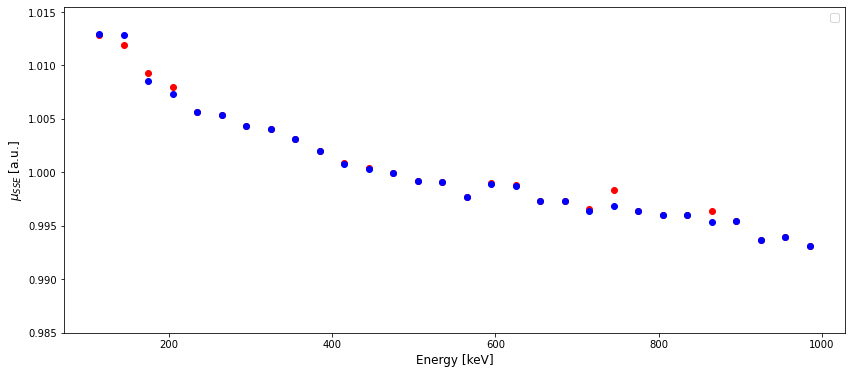

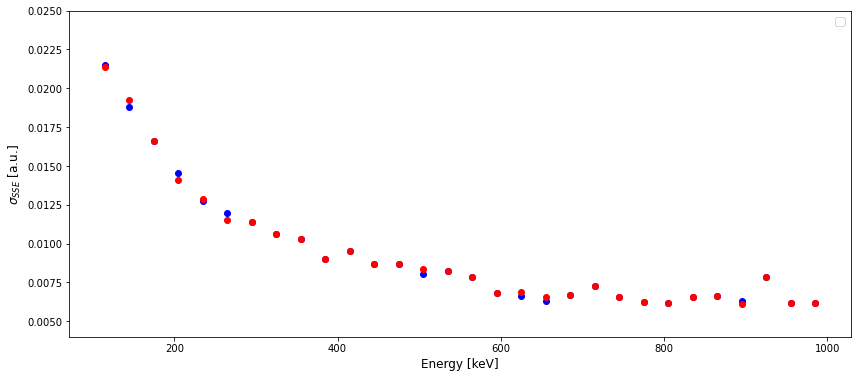

In [19]:
fig = plt.figure(figsize=(14,6))
coef = np.polyfit(xticks,meanstot_old,1)
coef2 = np.polyfit(xticks,meanstot_new,1)

poly1d_fn = np.poly1d(coef) 
poly1d_fn2 = np.poly1d(coef2) 

plt.scatter(xticks,meanstot_old, marker='o',  color='red')
plt.scatter(xticks,meanstot_new, marker='o',  color='blue' )


plt.ylim(min(meanstot_old),max(meanstot_old))
plt.ylabel('$\u03BC_{SSE}$ [a.u.]', fontsize=12)
plt.xlabel('Energy [keV]', fontsize=12)
plt.ylim(0.985,1.0155)
# plt.xticks(np.arange(100,1200,100))
# plt.xlim(305,800)
plt.legend(prop={'size': 12})


plt.savefig('plots/(edited)(LEGEND_mean)(115_to_%.f).pdf'%(w))

print(coef)
print(coef2)
#print(binw, '-----', n)
print(len(stdtot_new))

stdtot_old =  [abs(ele) for ele in stdtot_old]
# stdtot_new =  [abs(ele) for ele in stdtot_new]

fig = plt.figure(figsize=(14,6))
plt.scatter(xticks, stdtot_old, marker='o', color='b')
plt.scatter(xticks, stdtot_new, marker='o', color='red') 
E = np.arange(min(xticks), max(xticks), 1)
ss = 1/E 
# plt.plot(E,ss, color='k', linestyle='--', label = '1/E')
plt.ylabel('$\u03C3_{SSE}$ [a.u.]', fontsize=12)
plt.xlabel('Energy [keV]', fontsize=12)
# plt.xticks(np.arange(100,1200,100))
plt.ylim(0.004,0.025)
plt.legend(prop={'size': 12})

plt.savefig('plots/(edited)(LEGEND_sigma)(115_to_%.f).pdf'%(w))

# #binw = 0.0001, 0.0007